In [1]:
import torch
import numpy as np 
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from transformers import PretrainedConfig

In [2]:

class LMConfig(PretrainedConfig):
    """ 
    配置类
    """
    def __init__(
        self,
        
        max_seq_len: int = 512,#最大seq长度
        dim:int = 512, #embedding 维度  atten输入总维度
        

        n_layers: int =8, # 多少层

        n_heads: int  = 16, # 16个头 #每个head dim为 dim//n_heads
        n_kv_heads: int = 8, # 8个 kv头 ，（这里也就是说有8个组，每两个Query head共享一个kv）
        
        intermediate_size: int=None,  # mlp中间的 hidden_dim

        norm_eps: float=1e-5, # RmsNorm
        dropout: float=0.0,
        
        flash_atten: bool=True, # 是否使用flash attention

        **kwargs,
    ):
        super().__init__(**kwargs)

        self.n_layers = n_layers
        self.max_seq_len = max_seq_len
        self.dim = dim
        self.n_heads =  n_heads
        self.n_kv_heads = n_kv_heads 
        self.intermediate_size=intermediate_size 
        self.norm_eps = norm_eps 
        self.dropout=dropout

        self.flash_atten = flash_atten 



## 位置编码

由于Transformer的attention结构本身无法识别序列中元素的顺序-位置信息，因此引入了位置编码  

### 绝对位置编码：
给定一个词元 $u^t$ ,位置编码根据其在输入中的绝对位置分配一个固定长度的嵌入向量 $p^t ∈ R^H$。然后,每个词元对应的词向量和位置向量将**直接相加**,生成最终的输入嵌入序列 X =[x1, . . . , xT ]  

> 尽管绝对位置编码能够一定程度上建模位置信息,然  而它只能局限于建模训练样本中出现的位置,无法建模训练数据中未出现过的位置,因此极大地限制了它们处理长文本的能力

在原始的Transformer中采用了正余弦位置编码，  
该位置编码在不同维度上预先定义了特定的正弦或余弦函数，  
通过将词元的绝对位置输入带入这些函数，从而为这些维度赋值
对于维度大小为 H 的位置嵌入,其第 i ∈ {1, . . . , H} 维的值按照如下方法进行设置:
$$
p_{t,i} =
\begin{cases}
\sin\left(\dfrac{t}{10000^{\frac{(i-2)}{H}}}\right), &\text{ i  mod 2 = 0,} \\[2ex]
\sin\left(\dfrac{t}{10000^{\frac{(i-2)}{H}}}\right), &\text{ i  mod 2 = 1}, \\[2ex]
\end{cases}
$$

>绝对位置编码还可以采用可学习的嵌入表示,并被很多早期的预训练语言模型(如 BERT)广泛采用

### 相对位置编码：

相对位置编码是根据键和查询之间的偏移量计算得来的。
计算得来的相对位置编码通常应用于注意力矩阵的计算中，而不是直接与词元本身的位置编码相加。

> 与绝对位置编码相比,应用了相对位置编码的 Transformer  模型常常可以对比训练序列更长的序列进行建模,即具备一定的外推能力。

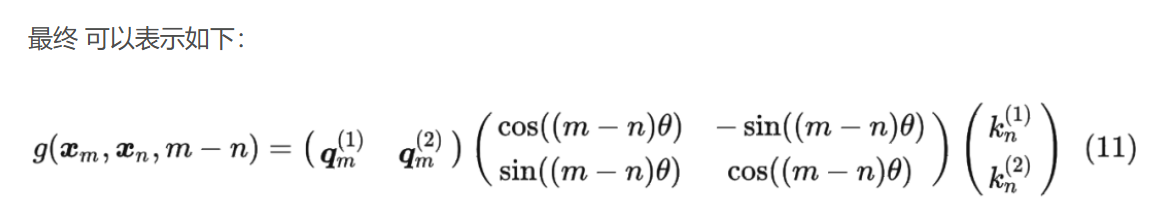
 
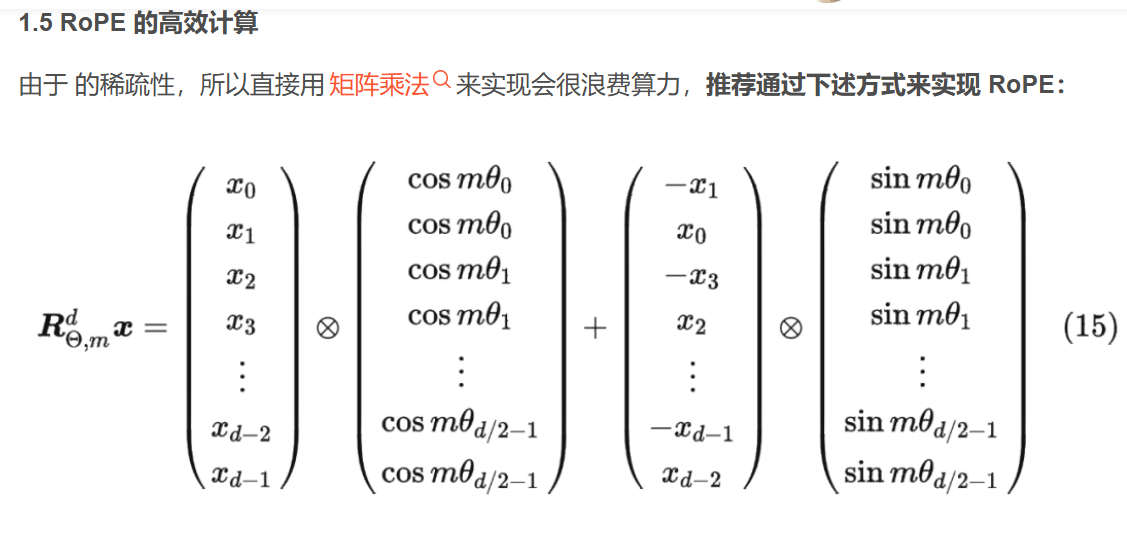

In [20]:
# LLaMa的ROPE
def rotate_half(x):
    # 这里并不是相邻两个元素x0,x1一个子空间， 而是诸如x0, xn/2这样子一个子空间
    x1 = x[..., : x.shape[-1]//2]
    x2 = x[..., x.shape[-1]//2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q,k,cos,sin,position_ids):

    #获得各个子空间旋转的正余弦值
    cos = cos[position_ids].unsqueeze(1)
    sin = sin[position_ids].unsqueeze(1)

    # 如上图高效计算公式，计算旋转后的q,k
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed 

torch.unsqueeze?

Docstring:
unsqueeze(input, dim) -> Tensor

Returns a new tensor with a dimension of size one inserted at the
specified position.

The returned tensor shares the same underlying data with this tensor.

A :attr:`dim` value within the range ``[-input.dim() - 1, input.dim() + 1)``
can be used. Negative :attr:`dim` will correspond to :meth:`unsqueeze`
applied at :attr:`dim` = ``dim + input.dim() + 1``.

Args:
    input (Tensor): the input tensor.
    dim (int): the index at which to insert the singleton dimension

Example::

    >>> x = torch.tensor([1, 2, 3, 4])
    >>> torch.unsqueeze(x, 0)
    tensor([[ 1,  2,  3,  4]])
    >>> torch.unsqueeze(x, 1)
    tensor([[ 1],
            [ 2],
            [ 3],
            [ 4]])
Type:      builtin_function_or_method

## Attention

相较于CNN需要不断叠加以扩大感受野，自注意力机制能够直接建模序列中任意两个位置的关系，进而有效捕获长程依赖，具有更强的序列建模能力。
相较于RNN无法并行，自注意力机制对于基于硬件的并行优化非常友好。

### 自注意力机制
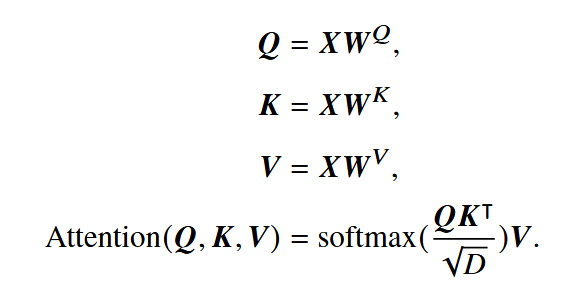

### 多头自注意力机制
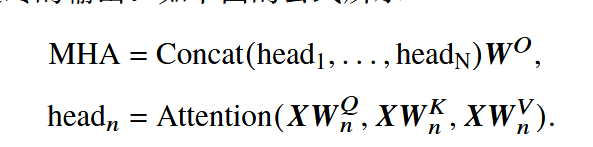

### 稀疏自注意力机制
注意力机制具有较强的建模能力，但是对于长度为T的序列需要$O(T^2)$的计算复杂度。
为此，引入稀疏注意力机制，（常用的是滑动窗口注意力机制 Sliding Window Attention ,SWA）  
**具体而言，滑动窗口设置为w，每个词元$u_t$仅仅考虑对窗口内的元素（$[u_{t-w+1},...,u_t]$）进行注意力计算，从而降低复杂度为O(wT),（模型通过层数线性增长的感受野获取长程依赖关系）**
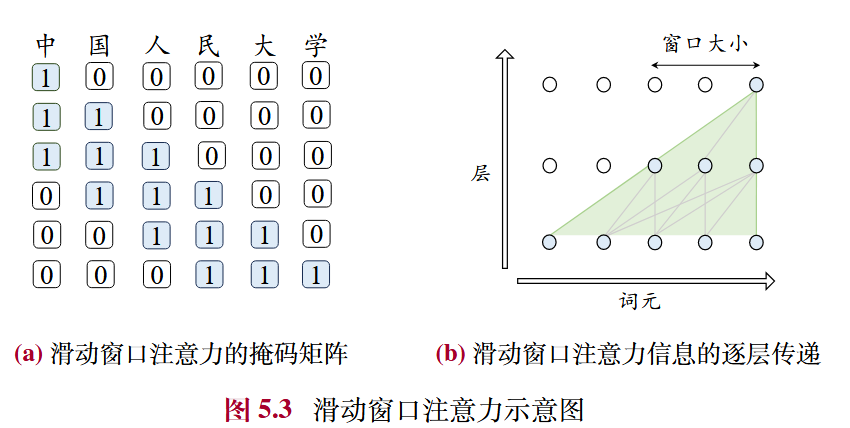


### 多查询/分组查询注意力

多查询注意力机制MQA：针对不同的查询头共享相同的键和值变换矩阵。
此方法减少访存量，提高速度并且对模型性能的影响较小
> 一些代表性的大语言模型,如 PaLM 和 StarCoder,已经使用了多查询注意力机制。

> 将MQA的效率与MHA的性能相结合，提出GQA分组查询注意力机制。
GQA将全部的头划分为若干组，组内的头共享相同的kv变换矩阵。该机制被Llama2使用。

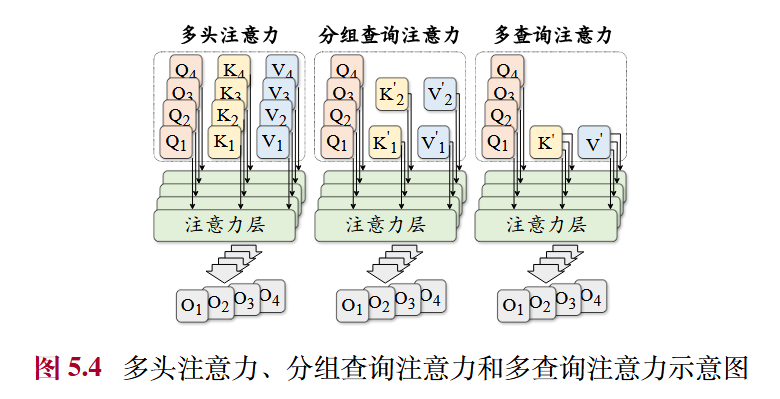

### 硬件优化的注意力机制(FlashAtten、PagedAtten)

除了在算法层面上提升注意力机制的计算效率，还可以进一步利用硬件设施来优化注意力模块的速度和内存消耗。

1. FlashAttention：通过矩阵分块计算以及减少内存读写次数的方式
2. PagedAttention: 针对解码阶段，对于KV缓存进行分块存储，优化计算方式，增大并行计算度


In [22]:
class SimpleAttention(nn.Module):
    """ 
    简单自注意力
    """
    def __init__(self,dim):
        super().__init__()
        self.dim = dim
        self.q = nn.Linear(dim,dim, bias=False)
        self.k = nn.Linear(dim,dim, bias=False)
        self.v = nn.Linear(dim,dim, bias=False)

    def forward(self,x, mask=None):
        # x.shape  (bs, seq, dim)

        q,k,v = self.q(x), self.k(x), self.v(x)
        weights = torch.matmul(q,torch.transpose(k,1,2))
        weights = weights*torch.rsqrt(self.dim)

        if mask is not None:
            weigths = weigths.masked_fill(mask==0,-float("inf"))
        weigths = torch.softmax(weights,dim=-1)

        return torch.matmul(weigths,v)




In [33]:
torch.transpose?
x = torch.Tensor([[1,2],
                  [3,4]])
torch.transpose(x,0,1),torch.transpose(x,1,0)

(tensor([[1., 3.],
         [2., 4.]]),
 tensor([[1., 3.],
         [2., 4.]]))

Docstring:
transpose(input, dim0, dim1) -> Tensor

Returns a tensor that is a transposed version of :attr:`input`.
The given dimensions :attr:`dim0` and :attr:`dim1` are swapped.

If :attr:`input` is a strided tensor then the resulting :attr:`out`
tensor shares its underlying storage with the :attr:`input` tensor, so
changing the content of one would change the content of the other.

If :attr:`input` is a :ref:`sparse tensor <sparse-docs>` then the
resulting :attr:`out` tensor *does not* share the underlying storage
with the :attr:`input` tensor.

If :attr:`input` is a :ref:`sparse tensor <sparse-docs>` with compressed
layout (SparseCSR, SparseBSR, SparseCSC or SparseBSC) the arguments
:attr:`dim0` and :attr:`dim1` must be both batch dimensions, or must
both be sparse dimensions. The batch dimensions of a sparse tensor are the
dimensions preceding the sparse dimensions.

.. note::
    Transpositions which interchange the sparse dimensions of a `SparseCSR`
    or `SparseCSC` layout tens

In [32]:
x = torch.tensor([1.,2,3])
x,x.masked_fill(x==1, -float("inf"))

(tensor([1., 2., 3.]), tensor([-inf, 2., 3.]))

In [ ]:
class MHA(nn.Module):
    """ 
    多头自注意力
    """
    def __init__(self,dim,heads):
        super().__init__()
        assert dim%heads == 0, "dim must be divisible by heads"
        self.dim=dim
        self.heads = heads
        self.head_dim = dim // heads 
        self.q = nn.Linear(dim, dim, bias= False)
        self.k = nn.Linear(dim, dim, bias= False)
        self.v = nn.Linear(dim, dim, bias= False)
        
        self.o = nn.Linear(dim, dim, bias= False)
    def forward(self, x, mask=None):
        # x.shape (bs,seq_len,dim)
        bs, seq_len, _ = x.size()
        q,k,v = self.q(x), self.k(x), self.v(x)
        # 变成(bs, heads, seq_len, head_dim)
        q = q.view(bs, seq_len,self.heads, self.head_dim).transpose(1,2)
        k = k.view(bs, seq_len,self.heads, self.head_dim).transpose(1,2)
        v = v.view(bs, seq_len,self.heads, self.head_dim).transpose(1,2)

        atten_weights = (
            q @ k.transpose(-2,-1) * torch.rsqrt(self.head_dim)
        )

        if mask is not None:
            atten_weights = atten_weights.masked_fill(mask==0, -float("inf"))
        atten_weights = F.softmax(atten_weights, dim=-1) 
        atten_scores = atten_weights @ v 

        # (bs, seq_len, heads, head_dim) --> (bs, seq_len, dim)  
        atten_scores = atten_scores.transpose(1,2).contiguous().view(bs, seq_len, self.dim)
        return self.o(atten_scores)




## view、reshape 与contiguous

> is_contiguous的直观解释为 Tensor底层一维数组存储顺序是否与Tensor按照行优先一维展开的元素顺序是否一致

Tensor.view 返回的是视图、数据共享内存，有contiguous的要求
而Tensor.reshape没有该要求，有可能不共享数据。

Tensor.reshape 可用到任何tensor上，
而Tensor.view仅仅在t.is_contiguous()==True时才对tensor t起作用。
一般用法为t.contiguous().view()

In [41]:
#view
z = torch.zeros((3,2))
x = z.view(2,3)
print(x.is_contiguous())
print(z)
x.fill_(1)
print(z)
print("="*10)
#reshape
z = torch.zeros((3,2))
x = z.reshape(2,3)
print(x.is_contiguous())
print(z)
x.fill_(1)
print(z)
print("="*10)
z.transpose(0,1).is_contiguous()

True
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
True
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])


False

In [35]:
torch.Tensor.contiguous?

Docstring:
contiguous(memory_format=torch.contiguous_format) -> Tensor

Returns a contiguous in memory tensor containing the same data as :attr:`self` tensor. If
:attr:`self` tensor is already in the specified memory format, this function returns the
:attr:`self` tensor.

Args:
    memory_format (:class:`torch.memory_format`, optional): the desired memory format of
        returned Tensor. Default: ``torch.contiguous_format``.
Type:      method_descriptor

In [ ]:
class Attention(nn.Module):
    def __init__(self, args:LMConfig):
        super().__init__()

        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        self.n_heads = args.n_heads 
        assert args.n_heads % args.n_kv_heads ==0 , "group error"

        self.n_local_heads = self.n_heads
        self.n_local_kv_heads = self.n_kv_heads
        self.n_rep = self.n_local_heads // self.n_local_kv_heads 
        self.head_dim = args.dim // args.n_heads #每个head dim为 dim//n_heads

        self.wq = nn.Linear(args.dim, self.n_heads * self.head_dim,bias = False)
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim,bias = False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim,bias = False)
        self.wo = nn.Linear(args.dim, args.dim,bias = False)

        self.k_cache, self.v_cache = None, None
        self.atten_dropout = nn.Dropout(args.dropout)
        self.resid_dropout = nn.Dropout(args.dropout) 
        self.dropout = args.dropout 
        #  Flash Attention requires PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention') and args.flash_atten 

        mask = torch.full((1,1,args.max_seq_len,args.max_seq_len),float("-inf"))
        mask = torch.triu(mask,diagonal=1)
        # buffer中的tensor可以理解为模型的常数
        # 只有buffers() 和 parameters()中的属性可以被state_dict保存
        # persistent=False， 不需要保存到state_dict中去
        self.register_buffer("mask", mask, persistent=False)
        
    def forward(self,x, poc_cis, kv_cache=False):
        # x (bs,sq_len,dim)
        bsz, seqlen, _ = x.shape

        xq,xk,xv = self.wq(x), self.wk(x), self.wv(x)
        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        # 旋转位置编码  相对位置
        xq, xk = apply_rotary_emb(xq,xk,poc_cis)

        # kv_cache
        if kv_cache and self.eval():
            if seqlen == 1 and all(cache is not None for cache in (self.k_vavhe,self.v_cache)):
                xk = torch.cat(())
        




## 前馈网络层
为了学习复杂的函数关系和特征，Transformer模型引入了一个前馈网络层FFN。  
对于每个位置的隐藏状态进行非线性变换和特征提取。



## 激活函数
FFN中激活函数的选择对LLMs的表现至关重要。
> 激活函数主要是为神经网络引入非线性变化，从而提高模型能力  

### ReLU
在原始的Transformer中使用的是ReLU激活函数。
$$
ReLU(x) = max(x,0)
$$

该激活函数计算较为简单,仅仅是将对输入中每个神经元和“零值”进行比较,并将小于零的神经元的值设置为 0。**然而,ReLU 可能会产生神经元失效的问题,被置为 0 的神经元将学习不到有用的信息**

### Swish
Swish 激活函数将神经元和该神经元的 sigmoid 激活的乘积作为新的激活函数
$$
Swish(x)=x \times sigmoid(x)
$$

### GELU 
GELU利用标准高斯累计分布函数作为激活函数
$$
GELU(x)  = 0.5x \times [1 + erf(x/\sqrt{2})], \\
erf(x) = \dfrac{2}{\sqrt{\pi}}\int_{1}^{x}e^{-t^2}dt
$$

### GLU 

GLU激活函数引入了两个不同的线性层，其中一个线性层的输出将被输入到一个激活函数（如GELU、Swish），
其结果将和另一个线性层的输出进行逐元素相乘。
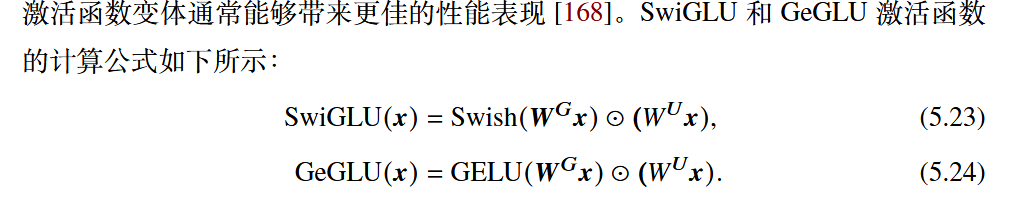


In [ ]:
class MLP(nn.Module):
    """ 
    选用SwiGLU激活函数
    """
    def __init__(self, args: LMConfig):
        super().__init__()
        self.hidden_size = args.dim 
        self.intermediate_size = args.intermediate_size
        self.act_fn = F.silu
        self.dropout = args.dropout

        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size,bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size,bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size,bias=False)
        self.dropout = nn.Dropout(args.dropout)
    def forward(self,x):
        inter = self.act_fn(self.gate_proj(x))*self.up_proj(x)
        return self.dropout(self.down_proj(inter))
        


## MOE混合专家网络

在大语言模型中引入基于稀疏激活的混合专家架构(MoE),旨在不显著提升计算成本的同时实现对于模型参数的拓展


在混合专家架构中,每个混合专家层包含 K 个专家组件,记为 $[E_1,  E_2, . . . , E_K ]$,  其中每个专家组件 $E_i$ 都是一个前馈神经网络。对于输入的每个词元表示 $x_t$ ,模  型通过一个路由网络(或称为门控函数)G 来计算该词元对应于各个专家的权重。在路由函数中,首先通过线性层 $W_G \in R^{H×K}$ 映射为 K 个专家的得分,并基于此选择出概率最高的 k 个专家进行激活。随后,这 k 个专家的得分将被送入 softmax 函数计算出它们的权重 $G (x_t) = [G (x_t)_1, . . . , G (x_t)_k]$,没有被选择的专家权重将被置为 0。

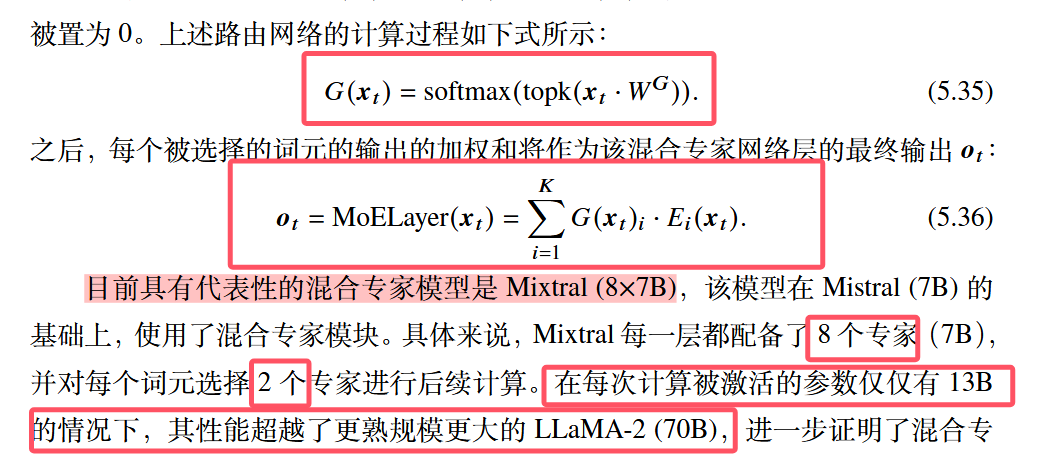


In [ ]:
from typing import List


class MoeLayer(nn.Module):
    def __init__(self, experts:List[nn.Module],gate: nn.Module,
                 num_experts_per_tok: int):
        super().__init__()
        assert len(experts)>0
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.num_experts_per_tok = num_experts_per_tok
    
    def forward(self, inputs: torch.Tensor):
        # inputs (bs, seq, dim)
        gate_logits = self.gate(inputs)
        # -> (bs, seq, num_experts) 每个位置选择的专家的得分

        
        # 选择topk个专家 -> (bs, seq, num_experts_per_tok) 
        weights, selected_experts_idx = torch.topk(gate_logits, self.num_experts_per_tok)

        # 计算每个专家的权重
        weights = F.softmax(weights,dim=-1, dtype=torch.float).to(inputs.dtype)

       # 将每个专家的输出加权求和
        results = torch.zeros_like(inputs)
        for i, expert in enumerate(self.experts):

            # 找到选择了当前专家的位置 即哪一个batch、哪一个token
            bs_idx, token_idx = torch.where(selected_experts_idx==i)
            results[bs_idx] += weights[bs_idx, token_idx, None] * \
                expert(inputs[bs_idx])
        return results




In [44]:
torch.topk?

Docstring:
topk(input, k, dim=None, largest=True, sorted=True, *, out=None) -> (Tensor, LongTensor)

Returns the :attr:`k` largest elements of the given :attr:`input` tensor along
a given dimension.

If :attr:`dim` is not given, the last dimension of the `input` is chosen.

If :attr:`largest` is ``False`` then the `k` smallest elements are returned.

A namedtuple of `(values, indices)` is returned with the `values` and
`indices` of the largest `k` elements of each row of the `input` tensor in the
given dimension `dim`.

The boolean option :attr:`sorted` if ``True``, will make sure that the returned
`k` elements are themselves sorted

Args:
    input (Tensor): the input tensor.
    k (int): the k in "top-k"
    dim (int, optional): the dimension to sort along
    largest (bool, optional): controls whether to return largest or
           smallest elements
    sorted (bool, optional): controls whether to return the elements
           in sorted order

Keyword args:
    out (tuple, optiona

In [50]:
x = torch.tensor([[1,2],[3,1]])
print(torch.where(x==1))
print(x.shape)
x = torch.tensor([[[1,2],
                    [3,1]]])
print(x.shape)
print(torch.where(x==1)) # 恰好 (0,0,0)和(0,1,1)位置符合
torch.where?

(tensor([0, 1]), tensor([0, 1]))
torch.Size([2, 2])
torch.Size([1, 2, 2])
(tensor([0, 0]), tensor([0, 1]), tensor([0, 1]))


Docstring:
where(condition, input, other, *, out=None) -> Tensor

Return a tensor of elements selected from either :attr:`input` or :attr:`other`, depending on :attr:`condition`.

The operation is defined as:

.. math::
    \text{out}_i = \begin{cases}
        \text{input}_i & \text{if } \text{condition}_i \\
        \text{other}_i & \text{otherwise} \\
    \end{cases}

.. note::
    The tensors :attr:`condition`, :attr:`input`, :attr:`other` must be :ref:`broadcastable <broadcasting-semantics>`.

Arguments:
    condition (BoolTensor): When True (nonzero), yield input, otherwise yield other
    input (Tensor or Scalar): value (if :attr:`input` is a scalar) or values selected at indices
                          where :attr:`condition` is ``True``
    other (Tensor or Scalar): value (if :attr:`other` is a scalar) or values selected at indices
                          where :attr:`condition` is ``False``

Keyword args:
    out (Tensor, optional): the output tensor.

Returns:
    Tensor:

## 层归一化和残差连接

在注意力和前馈网络后，模型使用层归一化和残差连接来加强模型的训练稳定度。  

残差连接将输入与该层输出相加，实现了信息在不同层的跳跃传递，进而缓解梯度爆炸和消失的问题。  

而LayerNorm则对数据进行重新缩放，提升模型的训练稳定性。  
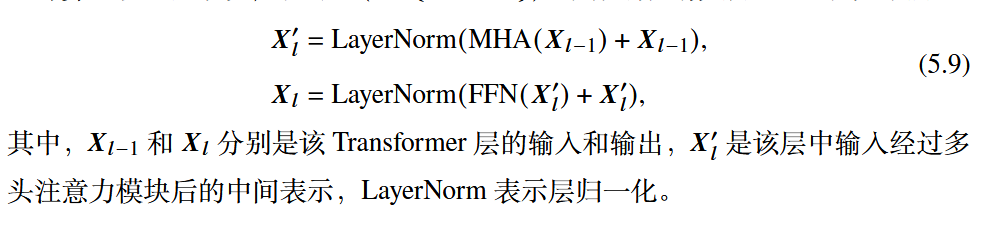

## 归一化方法
> 大语言模型预训练过程中经常出现不稳定的问题，因此通常使用特定的归一化策略来加强神经网络训练过程中的稳定性。

### 原始的Transformer模型使用LayerNorm， 
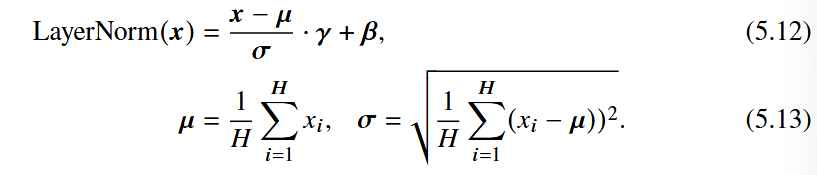

### 均方根层归一化RMSNorm 
为了提高层归一化的训练速度，RMSNorm仅仅利用激活值总和的均方根对激活值进行重新缩放，  
提高了训练速度和性能。
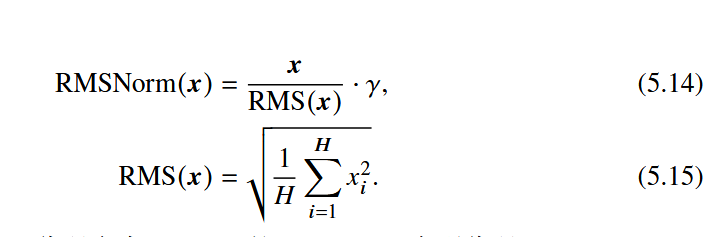

In [18]:
class RMSNorm(nn.Module):
    def __init__(self, args:LMConfig):
        super().__init__()

        self.hidden_size = args.dim 
        self.weight = nn.Parameter(torch.ones(self.hidden_size))
        self.variance_epsion = args.norm_eps
    def forward(self,hidden_state):
        # (bs, seq, dim)
        # dtype（数据类型）
        input_dtype = hidden_state.dtype
        hidden_state = hidden_state.to(torch.float32)
        # 计算均方根
        variance = hidden_state.pow(2).mean(-1, keepdim=True)
        # print("hidden state shape:"+str(hidden_state.shape))
        # print("shape:"+str(torch.rsqrt(variance + self.variance_epsion).shape))
        # 注意广播机制哇!!!
        hidden_state = hidden_state * torch.rsqrt(variance + self.variance_epsion)
        # 重新缩放，省去beta
        return self.weight * hidden_state.to(input_dtype)

rms = RMSNorm(LMConfig(dim=3))
input = torch.tensor([
    [1,1,1],
    [2,2,2]
    ])# 1*2*3
output = rms(input)
print(output)
x = torch.randn(2, 4)
print(x.pow(2).mean(-1))
print(x.pow(2).mean(-1,keepdim=True)) 
print(torch.rsqrt(x.pow(2).mean(-1,keepdim=True)))  

tensor([[0., 0., 0.],
        [0., 0., 0.]], grad_fn=<MulBackward0>)
tensor([4.1795, 0.1436])
tensor([[4.1795],
        [0.1436]])
tensor([[0.4891],
        [2.6390]])


### DeepNorm  
DeepNorm由微软提出，旨在稳定深层 Transformer 的训练。
> **DeepNorm 在LayerNorm的基础上，在残差连接中对之前的激活值x按照一定比例$\alpha$进行缩放**

通过这一简单的操作,Transformer 的  层数可以被成功地扩展至 1,000 层,进而有效提升了模型性能与训练稳定性。  

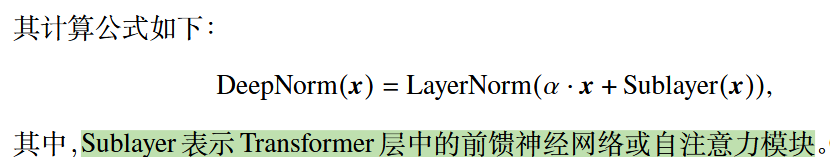

## 归一化位置 

为了加强大语言模型训练过程的稳定性,除了归一化方法外,归一化模块的位置也具有重要的影响。如图所示,归一化模块的位置通常有三种选择,分别是层后归一化(Post-Layer Normalization, Post-Norm)、层前归一化(Pre-Layer  Normalization, Pre-Norm)和夹心归一化(Sandwich-Layer Normalization, SandwichNorm)。

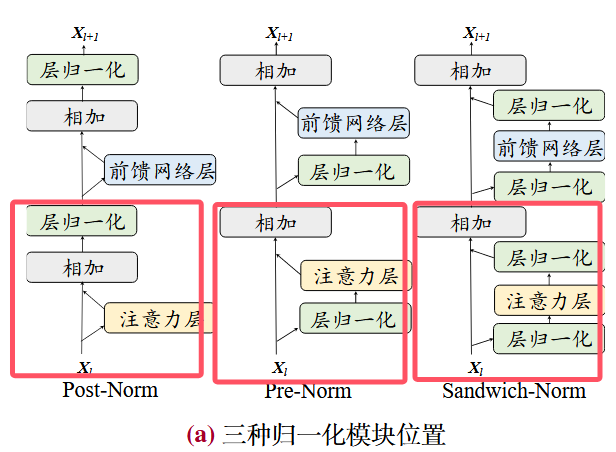

### PostNorm 
Post-Norm 是在原始 Transformer 模型中所使用的一种归一化技术。**其中,归一化模块被放置于残差计算之后。**  
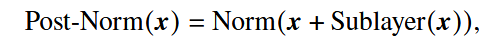  

> 在原理上，层后归一化具有很大优势

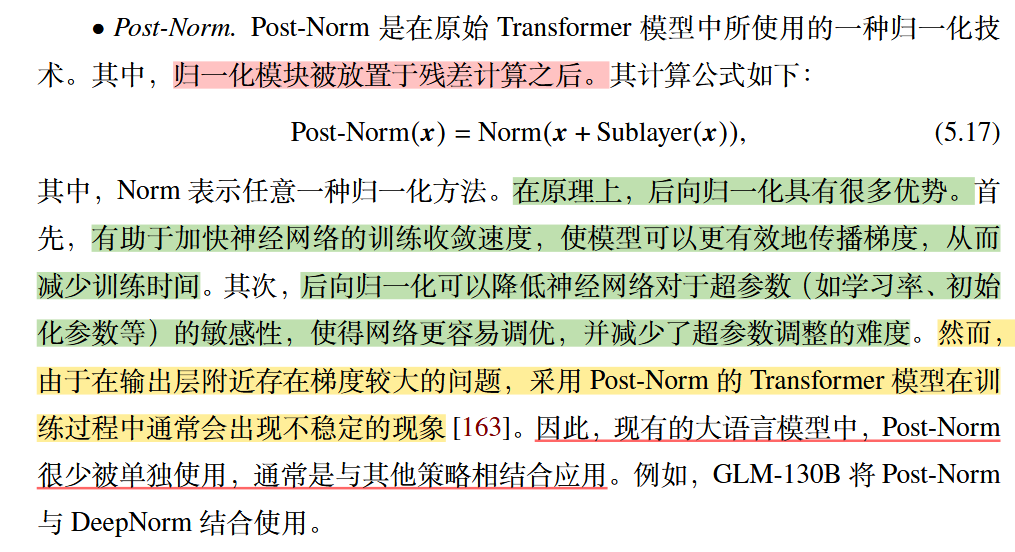

### PreNorm 
与 Post-Norm 不同,**Pre-Norm将归一化模块应用在每个子层之前。**

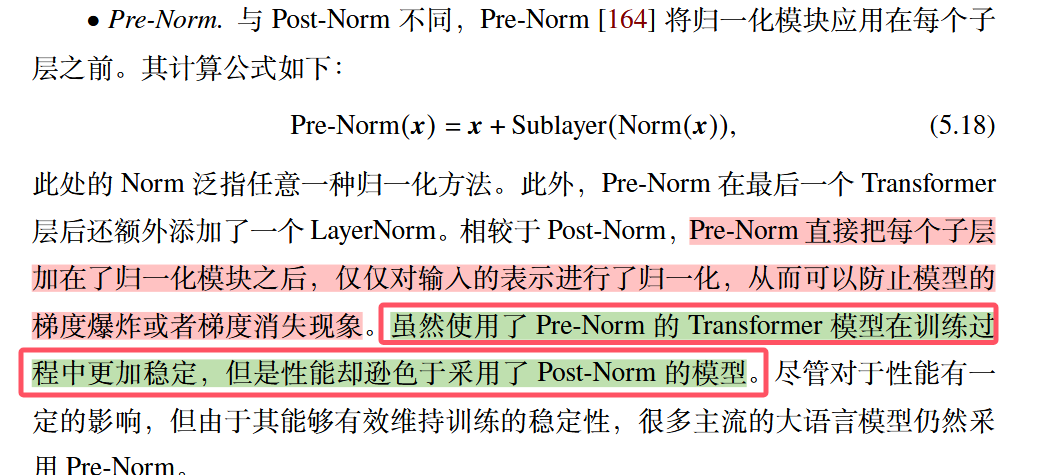 


### sandwich-Norm

在 Pre-Norm 的基础上,Sandwich-Norm在残差连接之前增加了额外的 LayerNorm,旨在避免 Transformer 层的输出出现数值爆炸的情况。

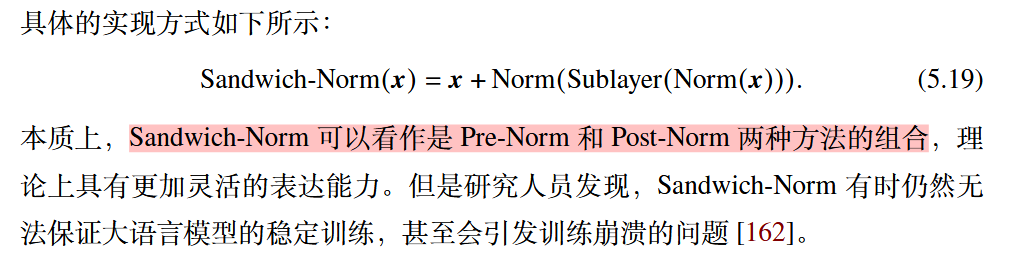